## Data Preparation

This notebook is used to clean and compile the spatio-temporal data used for the prediction exercise in our project. 

In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
import platform
from datetime import datetime, timedelta

import requests
from urllib.request import urlopen
import json
import os
from os import listdir

#viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker



pd.set_option('display.max_rows', 18)
pd.set_option('mode.chained_assignment', None) # need to be careful with this one!

In [15]:
def datetimer(cellstring):
    if cellstring == "Total":
        return cellstring
    strlist = cellstring.split(" ")
    return f"{strlist[1]}-{strlist[3]}"

In [16]:
datetimer("Year 2020 Week 01")

'2020-01'

## Preparing COVID-19 data by week $\times$ province.

In [18]:
# Taking the data straight from a csv from their pivot webpage. 
# In case of a serious non-one-off implementation, the data would
#  be pulled from the Finnish Institute of Health and Welfare's 
# API (which is NOT straightforward to use).

# COVID-19 data
path_to_file = os.path.join(os.getcwd(),'..','data/covid/fact_epirapo_covid19case.csv')
df_cov = pd.read_csv(path_to_file,sep = ";")

# Mapping between municipalities (province sub-unit) and province
path_to_file = os.path.join(os.getcwd(),'municipality_province_map.csv')
mun_prov = pd.read_csv(path_to_file,encoding = "ISO-8859-1",sep=";",header=1)

# Getting mapping that has all the different naming conventions of the different 
path_to_file = os.path.join(os.getcwd(),'mob_map_nuts3.txt')
prov_lang_map = pd.read_csv(path_to_file).iloc[:,1:]

In [20]:
# Making actual mappings (municipalities x provinces)
mun_prov_map = dict(zip(mun_prov.iloc[:,1],mun_prov.iloc[:,3]))
muns = list(mun_prov.iloc[:,1])

# Making actual mappings (provinces x naming conventions)
prov_lang_map = prov_lang_map[prov_lang_map.iloc[:,3] != 'Åland']
prov_fin_eng = dict(zip(prov_lang_map.iloc[:,1],prov_lang_map.iloc[:,3]))
provs = list(set(mun_prov.iloc[:,3]))

In [21]:
# Dropping everything but the municipalities (contains data about hospital district as well)
df_cov = df_cov[df_cov.iloc[:,1].isin(muns)]

# Dropping "kaikki ajat" aka "all times":
df_cov = df_cov[df_cov['Aika'] != 'Kaikki ajat']

# Mapping municipalities to the correct province
df_cov['province'] = df_cov.iloc[:,1].map(mun_prov_map)

# Dropping Ahvenanmaa (Åland) - the autonomous island we don't 
# analyze in this thing
df_cov = df_cov[df_cov.province != 'Ahvenanmaa']

# Resetting index after all this
df_cov.reset_index(drop=True,inplace=True)

# Setting val as int
df_cov['val'] = np.where(df_cov['val'] == '..',0,df_cov['val'])
df_cov['val'] = df_cov.val.astype(int)

# Grouping by both province and week
df_cov = df_cov.groupby(['province','Aika']).agg({'val' : 'sum'}).reset_index(drop=False)

# Pivoting, so that we get cases along dimensions (time x province)
df_cov_pivot = df_cov.pivot('Aika','province','val').reset_index(drop=False).rename_axis(None, axis=1)

# Putting it in the year-week format according to the rest of the data
df_cov_pivot['Y-W'] = df_cov_pivot.Aika.apply(datetimer)
df_cov_pivot.drop(columns=['Aika'],inplace=True)

# Data seems uniform - just how we like it!
print(df_cov.province.value_counts())

# Changing province names into English:
df_cov_pivot.rename(columns=prov_fin_eng,inplace=True)

Etelä-Karjala        115
Etelä-Pohjanmaa      115
Uusimaa              115
Satakunta            115
Päijät-Häme          115
Pohjois-Savo         115
Pohjois-Pohjanmaa    115
Pohjois-Karjala      115
Pohjanmaa            115
Pirkanmaa            115
Lappi                115
Kymenlaakso          115
Keski-Suomi          115
Keski-Pohjanmaa      115
Kanta-Häme           115
Kainuu               115
Etelä-Savo           115
Varsinais-Suomi      115
Name: province, dtype: int64


In [22]:
df_cov_pivot.head(10)
# df_cov_pivot.to_csv('/home/dante/SpatialData/spatial_project/data/processed/newcases_by_week_province.csv',index=False,)
# Please note that we are not saving our file here because we have done so before.
# If you want to replicate the analysis then please uncomment the above code line.

,Etelä-Karjala,Etelä-Pohjanmaa,Etelä-Savo,Kainuu,Kanta-Häme,Keski-Pohjanmaa,Keski-Suomi,Kymenlaakso,Lappi,Pirkanmaa,Pohjanmaa,Pohjois-Karjala,Pohjois-Pohjanmaa,Pohjois-Savo,Päijät-Häme,Satakunta,Uusimaa,Varsinais-Suomi,Y-W
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-02
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-03
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-04
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-05
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-06
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-07
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-08
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,2020-09
9,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,8,0,2020-10


In [23]:
# Applying conversion to look at our dependent variable
df_cov_pivot.iloc[:,0:-1] = df_cov_pivot.iloc[:,0:-1].apply(lambda x: np.log(x+1))

In [25]:
# Checking it out...
df_cov_pivot

,Etelä-Karjala,Etelä-Pohjanmaa,Etelä-Savo,Kainuu,Kanta-Häme,Keski-Pohjanmaa,Keski-Suomi,Kymenlaakso,Lappi,Pirkanmaa,Pohjanmaa,Pohjois-Karjala,Pohjois-Pohjanmaa,Pohjois-Savo,Päijät-Häme,Satakunta,Uusimaa,Varsinais-Suomi,Y-W
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-02
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-03
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-04
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,7.122060,7.262629,7.477038,6.529419,6.849066,6.354370,7.525640,7.446585,7.376508,8.236156,7.643004,6.423247,7.969012,7.140453,7.428333,7.534763,9.609586,8.185071,2022-06
111,7.258412,7.118016,7.674153,6.562444,6.747587,6.408529,7.305188,7.533159,7.558517,8.104703,7.770645,6.580639,7.962067,7.085064,7.436028,7.444249,9.433964,7.934513,2022-07
112,6.999422,7.061334,7.404888,6.599870,6.089045,6.220590,6.622736,7.328437,7.077498,7.385231,7.383989,6.075346,7.680637,6.767343,6.906755,7.143618,9.074406,7.742402,2022-08
113,7.120444,6.912743,7.385231,6.817831,6.445720,6.498282,6.919684,7.398786,6.936343,7.648263,7.438384,6.705639,7.974877,7.156177,6.898715,7.268920,9.279307,8.056744,2022-09


#### Visualizing the measure

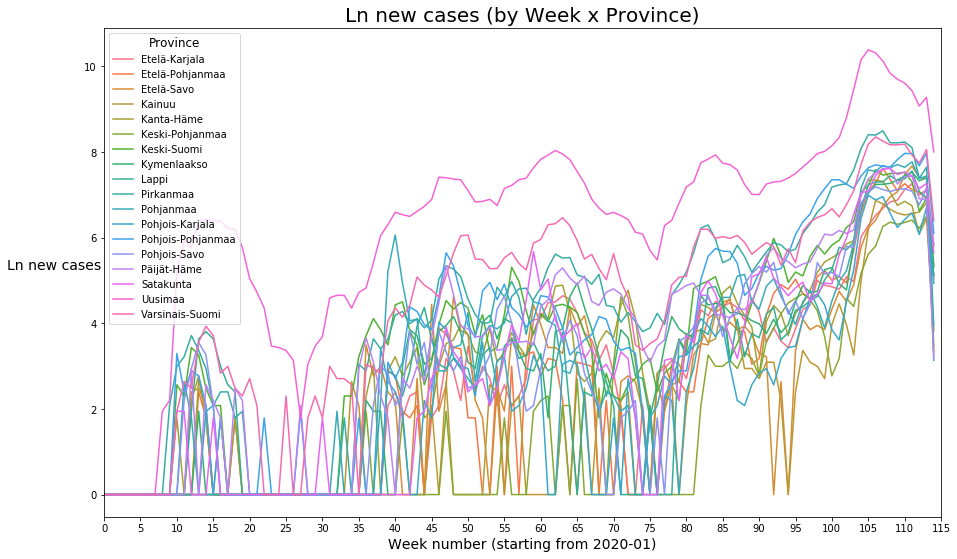

In [26]:
f = plt.figure()
f.set_figheight(9)
f.set_figwidth(15)

ax1 = f.add_subplot(111)



sns.lineplot(x='Y-W',
             y='value',
             hue = 'variable',
             data=pd.melt(df_cov_pivot, ['Y-W']),
             ax=ax1)

fontdict = {'fontsize': 20,
#  'fontweight' : rcParams['axes.titleweight'],
#  'verticalalignment': 'baseline',
#  'horizontalalignment': loc}
           }
plt.xlim(0,115)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.set_title(r"Ln new cases (by Week x Province)",fontdict = fontdict)
ax1.set_xlabel(r"Week number (starting from 2020-01)",fontsize=14)
ax1.set_ylabel(r"Ln new cases",rotation=0,labelpad=30,fontsize=14)



leg = plt.legend(title='Province', loc='upper left', labels=list(df_cov_pivot.columns[0:-1]))
# leg._legend_box.align = "top"
plt.setp(leg.get_title(),fontsize='large')
path_to_file = os.path.join(os.getcwd(),'../data/processed/new_cases_timeseries.png')
plt.savefig(path_to_file)
plt.show()

## Google intra-region mobility data

### Script that combines data from all years

In [27]:
# Specifying the path to the folder with google raw data
path_to_folder = os.path.join(os.getcwd(),'../data/google/')

# path = '/home/dante/SpatialData/spatial_project/data/google/'

# Getting the name of all files (2020-2022)
filelist = [file for file in os.listdir(path_to_folder) if '.csv' in file]

In [30]:
# Here are our Google datas
print(filelist)

['2021_FI_Region_Mobility_Report.csv', '2022_FI_Region_Mobility_Report.csv', '2020_FI_Region_Mobility_Report.csv']


In [32]:
# Specifying dtypes for faster processing of csv...
dtypes = {
    'country_region_code' : 'object',
    'country_region' : 'object',
    'sub_region_1' : 'object',
    'sub_region_2' : 'object',
    'metro_area' : 'object',
    'iso_3166_2_code' : 'object',
    'census_fips_code' : 'object',
    'place_id' : 'object',
    'date' : 'object',
    'retail_and_recreation_percent_change_from_baseline' : 'float64',
    'grocery_and_pharmacy_percent_change_from_baseline' : 'float64',
    'parks_percent_change_from_baseline' : 'float64',
    'transit_stations_percent_change_from_baseline' : 'float64',
    'workplaces_percent_change_from_baseline' : 'float64',
    'residential_percent_change_from_baseline' : 'float64',
}

# Assigning the correct column names
headers = list(dtypes.keys())

# Telling Pandas what column is a datecolumn (so that it can be parsed)
parse_dates = ['date']

# Creating a map between the ISO-codes of the different provinces and their ENG/FI/SWE 
# names, for legibility later on.
filepath = os.path.join(os.getcwd(),'mob_map_nuts3.txt')
df_codemap = pd.read_csv(filepath,sep=",")
iso_name_map = dict(zip(df_codemap.iloc[:,0],df_codemap.iloc[:,3]))

In [33]:
df_codemap

,Code,Subdivision name (fi),Subdivision name (sv),Subdivision Name (en),nuts_code,Subdivision name(engSTATFINLAND),thl_namings_eng
0,FI-02,Etelä-Karjala,Södra Karelen,South Karelia,FI1C5,South Karelia,South Karelia
1,FI-03,Etelä-Pohjanmaa,Södra Österbotten,Southern Ostrobothnia,FI194,South Ostrobothnia,Southern Ostrobothnia
2,FI-04,Etelä-Savo,Södra Savolax,Southern Savonia,FI1D1,South Savo,Southern Savonia
3,FI-05,Kainuu,Kajanaland,Kainuu,FI1D8,Kainuu,Kainuu
4,FI-06,Kanta-Häme,Egentliga Tavastland,Tavastia Proper,FI1C2,Kanta-Häme,Tavastia Proper
5,FI-07,Keski-Pohjanmaa,Mellersta Österbotten,Central Ostrobothnia,FI1D5,Central Ostrobothnia,Central Ostrobothnia
6,FI-08,Keski-Suomi,Mellersta Finland,Central Finland,FI193,Central Finland,Central Finland
7,FI-09,Kymenlaakso,Kymmenedalen,Kymenlaakso,FI1C4,Kymenlaakso,Kymenlaakso
8,FI-10,Lappi,Lappland,Lapland,FI1D7,Lapland,Lapland
9,FI-11,Pirkanmaa,Birkaland,Pirkanmaa,FI197,Pirkanmaa,Pirkanmaa


In [35]:
# Specifying empty dataframe for filling
df_list = []

for filename in filelist:
    # Specifying file location
    floc = path_to_folder + filename
    
    # Reading in file
    df_mr = pd.read_csv(floc,header=0,dtype=dtypes,names=headers,parse_dates=parse_dates)
    
    # Sorting values by date and sub_region_2,sub_region_1 as we want to be able to
    # look at the data in an intuitive way.
    df_mr.sort_values(by=['date','sub_region_2','sub_region_1'],inplace=True)
    
    df_mr['province'] = df_mr.iso_3166_2_code.map(iso_name_map)
    
    # Dropping unneccesary columns
    df_mr.drop(columns=['country_region_code','country_region','census_fips_code','iso_3166_2_code','place_id','metro_area','sub_region_2','sub_region_1'],inplace=True)

    # Specifying down our data to the province level
    df_mr.dropna(subset=['province'],inplace=True)
    df_mr.reset_index(drop=True,inplace=True)

    # Casting date in correct format (apparently Pandas doesn't actually read the dtypes correctly)
    df_mr['date'] = pd.to_datetime(df_mr.date)

    # Adding day of year for gap checking if needed
    df_mr['dayofyear'] = df_mr['date'].dt.dayofyear

    # Defining the movement data columns of interest
    # and filling in NaNs with 0 (i.e no change/information).
    # I do not know how sustainable this assumption is...
    mvcols = [col for col in df_mr.columns if 'baseline' in col]
    values = {col : 0 for col in mvcols}
    df_mr.fillna(value=values, inplace=True)
    
    
    for prov in iso_name_map.values():
    
        # Specify the correct province 
        df = df_mr[df_mr.province == prov]

        # The below code bins the data according to week commencing MONDAY
        # This code looks complicated, but achieves something quite understanable.
        df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
        df = df.groupby([pd.Grouper(key='date', freq='W-MON')])[mvcols].mean().reset_index().sort_values('date')

        # Creating the column with which we can then merge to the cases data..
        df['Y-W'] = df.date.dt.year.astype(str)+'-'+df.date.dt.isocalendar().week.astype(str)

        # Adding name of province
        df['province'] = prov
        df.reset_index(drop=True) 

        # Finally, appending to the list of dfs...
        df_list.append(df)
    
# Finally, concatenating the whole list
combined_mv_df = pd.concat(df_list)

In [36]:
combined_mv_df[(combined_mv_df.province == 'Uusimaa') & (combined_mv_df.date == '2020-12-28')]

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Y-W,province
0,2020-12-28,-40.250000,-24.000000,3.500000,-56.000000,-39.750000,13.250000,2020-53,Uusimaa
46,2020-12-28,-23.666667,-0.333333,-1.333333,-54.333333,-62.333333,16.333333,2020-53,Uusimaa


In [37]:
# Lets see that the number of observations per province match up...
for idx,prov in enumerate(combined_mv_df.province.value_counts().index):
    datas = combined_mv_df[combined_mv_df.province == prov].shape
    print(f"Province {idx+1}, shape : {datas}")

Province 1, shape : (109, 9)
Province 2, shape : (109, 9)
Province 3, shape : (109, 9)
Province 4, shape : (109, 9)
Province 5, shape : (109, 9)
Province 6, shape : (109, 9)
Province 7, shape : (109, 9)
Province 8, shape : (109, 9)
Province 9, shape : (109, 9)
Province 10, shape : (109, 9)
Province 11, shape : (109, 9)
Province 12, shape : (109, 9)
Province 13, shape : (109, 9)
Province 14, shape : (109, 9)
Province 15, shape : (109, 9)
Province 16, shape : (109, 9)
Province 17, shape : (109, 9)
Province 18, shape : (109, 9)


In [30]:
# Saving the file as a CSV.
# combined_mv_df.to_csv('/home/dante/SpatialData/spatial_project/data/processed/google_mobility_by_week_province.csv',index=False)
# Please note that we are not saving our file here because we have done so before.
# If you want to replicate the analysis then please uncomment the above code line.

In [38]:
combined_mv_df.sort_values(by=['province','date'],inplace=True)
# combined_mv_df[combined_mv_df.province == 'Uusimaa'].head(120)

## FB inter-region connectivity data

### Creating the Social Proximity to Cases Variable

In [46]:
df_sci_loc = os.path.join(os.getcwd(),'../data/processed/fb_sci_by_province.csv')
df_cov_loc = os.path.join(os.getcwd(),'../data/processed/newcases_by_week_province.csv')
mapping_loc = os.path.join(os.getcwd(),'mob_map_nuts3.txt')
population_data_loc = os.path.join(os.getcwd(),'../data/municipal/municipal_population.txt')

print(df_sci_loc)
print(df_cov_loc)
print(mapping_loc)
print(population_data_loc)

df_sci = pd.read_csv(df_sci_loc)
df_cov = pd.read_csv(df_cov_loc)
prov_nam_conv = pd.read_csv(mapping_loc)
mun_pop = pd.read_csv(population_data_loc,header=0,encoding = "UTF-8",sep="\t")

/home/dante/SpatialData/spatial_project/scripts/../data/processed/fb_sci_by_province.csv
/home/dante/SpatialData/spatial_project/scripts/../data/processed/newcases_by_week_province.csv
/home/dante/SpatialData/spatial_project/scripts/mob_map_nuts3.txt
/home/dante/SpatialData/spatial_project/scripts/../data/municipal/municipal_population.txt


In [48]:
# Collecting provincial information
prov_pop = mun_pop.iloc[310:328,:]

# Casting the population figures as INT
prov_pop.iloc[:,1] = prov_pop.iloc[:,1].str.replace(",","").astype(int)
prov_pop.reset_index(drop=True)

# Sorting values for easier legibility
prov_pop.sort_values(by=prov_pop.columns[0],inplace=True)

prov_pop['province'] = prov_pop['Population'].map(dict(zip(prov_nam_conv.iloc[:,-2],prov_nam_conv.iloc[:,3])))

# Making province : population dict for division later...
prov_pop_dict = dict(zip(prov_pop.iloc[:,2],prov_pop.iloc[:,1]))

In [49]:
# Below, you'll see the dict with province x population
prov_pop_dict

{'Central Finland': 272617,
 'Central Ostrobothnia': 67988,
 'Kainuu': 71664,
 'Tavastia Proper': 170577,
 'Kymenlaakso': 162812,
 'Lapland': 176665,
 'North Karelia': 163537,
 'Northern Ostrobothnia': 413830,
 'Northern Savonia': 248265,
 'Ostrobothnia': 175816,
 'Pirkanmaa': 522852,
 'Päijänne Tavastia': 205771,
 'Satakunta': 215416,
 'South Karelia': 126921,
 'Southern Ostrobothnia': 192150,
 'Southern Savonia': 132702,
 'Southwest Finland': 481403,
 'Uusimaa': 1702678}

In [50]:
# Changing names from THL convention to the convention we have been using.
df_cov.rename(columns=dict(zip(prov_nam_conv.iloc[:,-1],prov_nam_conv.iloc[:,-4])),inplace=True)

In [51]:
# Having a peek at our data...
df_cov.head(10)

,South Karelia,Southern Ostrobothnia,Southern Savonia,Kainuu,Tavastia Proper,Central Ostrobothnia,Central Finland,Kymenlaakso,Lapland,Pirkanmaa,Ostrobothnia,North Karelia,Northern Ostrobothnia,Northern Savonia,Päijänne Tavastia,Satakunta,Uusimaa,Southwest Finland,Y-W
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-02
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-03
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-04
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-05
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-06
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-07
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-08
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,2020-09
9,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,8,0,2020-10


In [52]:
# Creating a copy of the COVID df so that we can always restart
# the modifications from here.
df_cov_c = df_cov.copy()

# The below for-loop scales the covid cases for each day x province 
# to the level of new cases per 10k people. In this way, we are stand-
# ardizing the measurement across provinces.
for idx,prov in enumerate(df_cov.columns[0:-1]):
    #FOR EACH PROVINCE

    # For each province, fetch the population of the province,
    # and then divide the whole time series for that province
    # by the population.
    case_by_pop = df_cov_c[prov] / prov_pop_dict[prov]
    
    # Multiply the per capita number by 10000, to get cases
    # per 10k people.
    case_by_10k = case_by_pop * 10000
    
    # Assign back to the dataframe.
    df_cov_c[prov] = case_by_10k

In [53]:
df_cov_c

,South Karelia,Southern Ostrobothnia,Southern Savonia,Kainuu,Tavastia Proper,Central Ostrobothnia,Central Finland,Kymenlaakso,Lapland,Pirkanmaa,Ostrobothnia,North Karelia,Northern Ostrobothnia,Northern Savonia,Päijänne Tavastia,Satakunta,Uusimaa,Southwest Finland,Y-W
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-02
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-03
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-04
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,97.540990,74.160812,133.080134,95.445412,55.224327,84.426664,68.007498,105.213375,90.397079,72.181038,118.589889,37.606169,69.811275,50.792500,81.741353,86.855201,87.544445,74.490604,2022-06
111,111.801829,64.168618,162.092508,98.654834,49.889493,89.133376,54.545388,114.733558,108.453853,63.287508,134.743141,44.026734,69.327985,48.053491,82.373124,79.334868,73.443129,57.976373,2022-07
112,86.274139,60.629716,123.811246,102.422416,25.794802,73.836559,27.547805,93.482053,67.019500,30.811778,91.516131,26.538337,52.316168,34.962641,48.500518,58.723586,51.260426,47.839336,2022-08
113,97.383412,52.250846,121.399828,127.400089,36.874842,97.517209,37.084995,100.299732,58.189228,40.087826,96.635119,49.896965,70.222072,51.598091,48.111736,66.568871,62.918532,65.516833,2022-09


In [54]:
df_sci.head(20)

,user_loc,fr_loc,scaled_sci,sci_weights,sci_tot,user_loc_province,fr_loc_province
0,FI193,FI194,194521,0.084726,2295870,Central Finland,Southern Ostrobothnia
1,FI193,FI195,63308,0.027575,2295870,Central Finland,Ostrobothnia
2,FI193,FI196,82296,0.035845,2295870,Central Finland,Satakunta
3,FI193,FI197,193217,0.084159,2295870,Central Finland,Pirkanmaa
4,FI193,FI1B1,113537,0.049453,2295870,Central Finland,Uusimaa
...,...,...,...,...,...,...,...
15,FI193,FI1D8,135387,0.058970,2295870,Central Finland,Kainuu
16,FI193,FI1D9,114741,0.049977,2295870,Central Finland,Northern Ostrobothnia
17,FI194,FI193,194521,0.085983,2262307,Southern Ostrobothnia,Central Finland
18,FI194,FI195,422753,0.186868,2262307,Southern Ostrobothnia,Ostrobothnia


In [55]:
# Mapping GADM NUTS3 code to our used standard for the province name
mob_map = dict(zip(prov_nam_conv.iloc[:,4],prov_nam_conv.iloc[:,3]))

# Creating a map between SCI weights of a given province and all OTHERS.
sci_dict = {}
for prov in df_sci.user_loc_province.value_counts().index:
    # FOR EACH PROVINCE
    
    # Get list of all other provinces, i.e. not the one that is being
    # considered in the loop (because this was already deleted earlier
    # when I made the fb_sci_by_province.csv file).
    fr_list = list(df_sci[(df_sci.user_loc_province == prov)].fr_loc_province)
    
    # Get the list of all other province weights.
    sci_weights_list = list(df_sci[(df_sci.user_loc_province == prov)].sci_weights)
    
    # Assign the list of all other province weights to a dictionary, with the name
    # of the 'parent' province.
    sci_dict[prov] = {fr_loc:sci_weight for fr_loc,sci_weight in zip(fr_list,sci_weights_list)}


# The SCI-dict looks as follows:
# sci_dict

In [56]:
# FINALLY, we can create the SCI-weighted data!

# Creating a final dataframe to write to.
df_spc = df_cov.copy()

for prov in sci_dict.keys():
    #FOR PROVINCE IN THE SCI-DICT
    
    # Creating a local copy for computation
    df = df_cov_c.copy()
    
    # Get the weights for the province
    weights = sci_dict[prov]
    
    # Then, we weigh the local copy of the dataframe
    # by the weights in the sci_dict
    for neigh_prov in weights.keys():  
        #FOR EACH PROVINCE APART FROM prov
        
        # Weighting the observations by SCI weights
        df[neigh_prov] = df[neigh_prov]*weights[neigh_prov]
    
    # Collecting the names of the neighbors
    neighs = list(weights.keys())
    
    # Summing the weighted observations across all provinces 
    # not equal to the province we are processing the data for.
    df_spc[prov] = df[neighs].sum(axis=1)
    
    # Setting the data to the correct format (i.e ln(x+1)) so
    # that we won't have minus-valued predicted cases.
    df_spc[prov] = np.log(df_spc[prov]+1)

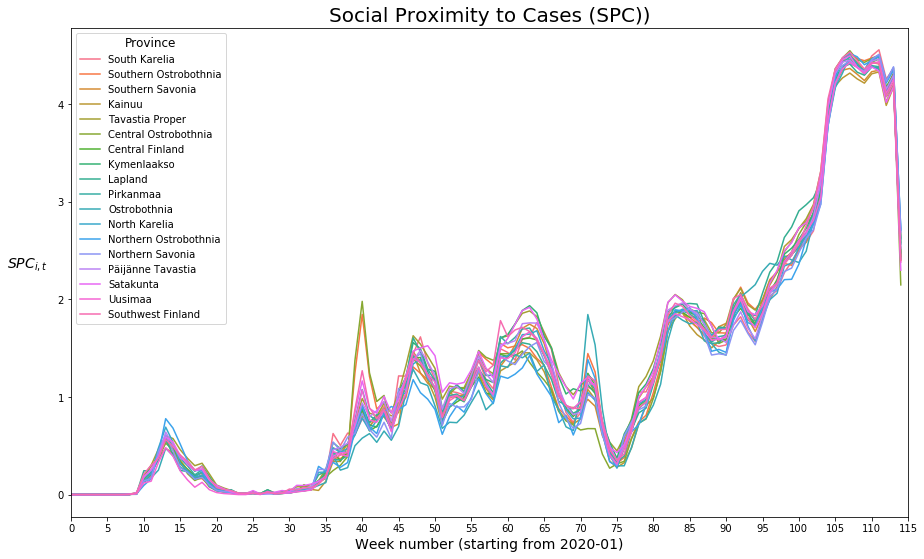

In [57]:
f = plt.figure()
f.set_figheight(9)
f.set_figwidth(15)

ax1 = f.add_subplot(111)



sns.lineplot(x='Y-W',
             y='value',
             hue = 'variable',
             data=pd.melt(df_spc, ['Y-W']),
             ax=ax1)

fontdict = {'fontsize': 20,
#  'fontweight' : rcParams['axes.titleweight'],
#  'verticalalignment': 'baseline',
#  'horizontalalignment': loc}
           }
plt.xlim(0,115)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.set_title(r"Social Proximity to Cases (SPC))",fontdict = fontdict)
ax1.set_xlabel(r"Week number (starting from 2020-01)",fontsize=14)
ax1.set_ylabel(r"$SPC_{i,t}$",rotation=0,labelpad=30,fontsize=14)



leg = plt.legend(title='Province', loc='upper left', labels=list(df_spc.columns[0:-1]))
# leg._legend_box.align = "top"
plt.setp(leg.get_title(),fontsize='large')

path_to_file = os.path.join(os.getcwd(),'../data/processed/SPC_timeseries.png')
plt.savefig(path_to_file)
plt.show()

- I have a feeling that these are always driven by Uusimaa..

In [58]:
# This now holds the SCI weighted cases!    
df_spc.head(15)

# df_spc.to_csv('/home/dante/SpatialData/spatial_project/data/processed/spc_by_week_province.csv',index=False)
# Please note that we are not saving our file here because we have done so before.
# If you want to replicate the analysis then please uncomment the above code line.

,South Karelia,Southern Ostrobothnia,Southern Savonia,Kainuu,Tavastia Proper,Central Ostrobothnia,Central Finland,Kymenlaakso,Lapland,Pirkanmaa,Ostrobothnia,North Karelia,Northern Ostrobothnia,Northern Savonia,Päijänne Tavastia,Satakunta,Uusimaa,Southwest Finland,Y-W
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-02
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-03
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-04
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-05
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-06
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-07
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-08
8,0.001987,0.001319,0.001657,0.001291,0.003026,0.001151,0.001741,0.002632,0.001775,0.001977,0.001740,0.001753,0.001322,0.001442,0.002689,0.001836,0.000000,0.002860,2020-09
9,0.008440,0.013733,0.007392,0.007570,0.020802,0.007801,0.013499,0.010183,0.009988,0.002635,0.008742,0.008346,0.007621,0.007862,0.012190,0.021035,0.009012,0.014241,2020-10


## Weather data
- The weather data was gathered from the Finnish Meteorological Institute (FMI)
https://en.ilmatieteenlaitos.fi/download-observations.

In [59]:
filepath = os.path.join(os.getcwd(),'../data/weather/')
# filepath = '/home/dante/SpatialData/spatial_project/data/weather/'
filelist = [file for file in os.listdir(filepath) if '.csv' in file]
prov_loc = os.path.join(os.getcwd(),'mob_map_nuts3.txt')
provinces = pd.read_csv(prov_loc,sep=',').iloc[:,3].values.tolist()

In [60]:
# Initializing an empty list to fill with weather data
df_list = []

for idx,prov in enumerate(provinces):
    # FOR EACH PROVINCE NAME
    
    # Create filename
    path2data = filepath + str(prov) + '.csv'
    
    # Fetch data, parse it
    df = pd.read_csv(path2data,
                     parse_dates = {"date" : ["Year","m","d"]},
                     dtype = {'Time zone' : 'object',
                              'Precipitation amount (mm)' : 'float64',
                              'Maximum temperature (degC)' : 'float64',
                              'Minimum temperature (degC)' : 'float64'},
#                      nrows=1,
                     header=0)
    
    print(df.shape)
    # Assigning columns of interest
    cols = list(df.columns)[2:]
        
    # The below code bins the data according to week commencing MONDAY
    # This code looks complicated, but achieves something quite understanable.
    df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
    df = df.groupby([pd.Grouper(key='date', freq='W-MON')])[cols].mean().reset_index().sort_values('date')

    # Creating the column with which we can then merge to the cases data..
    df['Y-W'] = df.date.dt.year.astype(str)+'-'+df.date.dt.isocalendar().week.astype(str)
    
    if idx == 0:
        y_w = df['Y-W']
    
    # Adding name of province
    df['province'] = prov
    df.reset_index(drop=True) 
    
    # Setting first week of January to start on 2020-01-01
    # as per data from THL (covid source)
    df.iloc[0,-2] = '2020-1'

    # Finally, appending to the list of dfs...
    df_list.append(df)
    


# concatenating it all into one big df...
weather_data = pd.concat(df_list)

(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)
(800, 6)


In [46]:
# weather_data.pivot('date','province','Maximum temperature (degC)').head(150).reset_index().isna().sum()
# weather_data.pivot('date','province','Minimum temperature (degC)').head(150).reset_index().isna().sum()

In [61]:
# Getting the max temperature reading per weep for all provinces
max_temp_data = weather_data.pivot('date','province','Maximum temperature (degC)')
max_temp_data['Y-W'] = y_w.values
max_temp_data.reset_index(drop=False)

# Getting the min temperature reading per weep for all provinces
min_temp_data = weather_data.pivot('date','province','Minimum temperature (degC)')
min_temp_data['Y-W'] = y_w.values
min_temp_data.reset_index(drop=False)

province,date,Central Finland,Central Ostrobothnia,Kainuu,Kymenlaakso,Lapland,North Karelia,Northern Ostrobothnia,Northern Savonia,Ostrobothnia,Pirkanmaa,Päijänne Tavastia,Satakunta,South Karelia,Southern Ostrobothnia,Southern Savonia,Southwest Finland,Tavastia Proper,Uusimaa,Y-W
0,2019-12-30,-3.516667,-1.483333,-3.483333,-3.600000,-9.500000,-5.483333,-9.683333,-3.033333,0.083333,-1.366667,-3.016667,-0.300000,-2.950000,-1.300000,-4.433333,0.700000,-1.966667,0.416667,2020-1
1,2020-01-06,-1.657143,-1.114286,-1.471429,-1.642857,-6.414286,-2.757143,-7.057143,-0.657143,0.585714,-1.285714,-1.700000,-0.242857,-1.114286,-1.642857,-1.542857,-0.585714,-1.300000,1.071429,2020-2
2,2020-01-13,-0.585714,-1.457143,-2.171429,0.928571,-8.957143,-0.800000,-8.442857,-0.200000,-1.071429,1.371429,1.200000,2.342857,0.657143,-0.914286,0.471429,2.585714,1.328571,2.928571,2020-3
3,2020-01-20,-5.600000,-5.285714,-9.457143,-3.028571,-14.628571,-7.271429,-16.985714,-5.885714,-1.328571,-1.857143,-2.657143,-0.428571,-3.500000,-4.600000,-5.457143,0.014286,-1.585714,0.285714,2020-4
4,2020-01-27,-3.900000,-3.157143,-8.285714,-2.471429,-12.385714,-7.714286,-11.114286,-5.700000,-1.385714,-0.957143,-1.785714,0.500000,-3.471429,-2.342857,-3.185714,1.285714,-0.942857,1.242857,2020-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2022-02-07,-6.014286,-8.742857,-9.814286,-4.671429,-12.228571,-7.357143,-12.771429,-5.528571,-6.328571,-5.071429,-5.471429,-2.685714,-3.671429,-10.057143,-5.314286,-3.285714,-5.114286,-2.042857,2022-6
111,2022-02-14,-4.885714,-8.185714,-8.257143,-2.885714,-11.814286,-3.714286,-13.314286,-4.128571,-6.785714,-3.100000,-2.814286,-3.042857,-2.542857,-8.128571,-3.385714,-2.671429,-3.485714,-0.828571,2022-7
112,2022-02-21,-11.057143,-9.685714,-12.800000,-7.400000,-12.057143,-10.842857,-11.771429,-10.600000,-7.028571,-8.314286,-8.485714,-4.785714,-6.914286,-9.000000,-10.171429,-4.585714,-9.200000,-4.500000,2022-8
113,2022-02-28,-6.585714,-7.014286,-7.857143,-7.371429,-7.228571,-9.485714,-7.728571,-6.828571,-3.957143,-5.571429,-7.442857,-3.000000,-6.342857,-7.571429,-8.500000,-3.114286,-6.328571,-3.014286,2022-9


In [48]:
# min_temp_data.to_csv('/home/dante/SpatialData/spatial_project/data/processed/min_temp_by_week_province.csv',index=False)
# max_temp_data.to_csv('/home/dante/SpatialData/spatial_project/data/processed/max_temp_by_week_province.csv',index=False)
# Please note that we are not saving our file here because we have done so before.
# If you want to replicate the analysis then please uncomment the above code line.

## Creating final dataset

In [65]:
# Temperature data
temp_min_loc = os.path.join(os.getcwd(),'../data/processed/min_temp_by_week_province.csv')
temp_max_loc = os.path.join(os.getcwd(),'../data/processed/max_temp_by_week_province.csv')
df_temp_min = pd.read_csv(temp_min_loc)
df_temp_max = pd.read_csv(temp_max_loc)

# Google mobility data
mobility_loc = os.path.join(os.getcwd(),'../data/processed/google_mobility_by_week_province.csv')
df_mobility = pd.read_csv(mobility_loc)

# Social Proximity to Cases data
spc_loc = os.path.join(os.getcwd(),'../data/processed/spc_by_week_province.csv')
df_spc = pd.read_csv(spc_loc)

# New cases by week by province data
covid_loc = os.path.join(os.getcwd(),'../data/processed/newcases_by_week_province.csv')
df_covid = pd.read_csv(covid_loc)

In [66]:
# The data will all be merged into this one dataframe:
df_master = pd.DataFrame()

In [67]:
# Taking the Y-W denotations to create a map later on.
yw_list = df_covid['Y-W'].value_counts().index.tolist()

In [68]:
yw_list.sort()
yw_list

['2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06',
 '2020-07',
 '2020-08',
 '2020-09',
 '2020-10',
 '2020-11',
 '2020-12',
 '2020-13',
 '2020-14',
 '2020-15',
 '2020-16',
 '2020-17',
 '2020-18',
 '2020-19',
 '2020-20',
 '2020-21',
 '2020-22',
 '2020-23',
 '2020-24',
 '2020-25',
 '2020-26',
 '2020-27',
 '2020-28',
 '2020-29',
 '2020-30',
 '2020-31',
 '2020-32',
 '2020-33',
 '2020-34',
 '2020-35',
 '2020-36',
 '2020-37',
 '2020-38',
 '2020-39',
 '2020-40',
 '2020-41',
 '2020-42',
 '2020-43',
 '2020-44',
 '2020-45',
 '2020-46',
 '2020-47',
 '2020-48',
 '2020-49',
 '2020-50',
 '2020-51',
 '2020-52',
 '2020-53',
 '2021-01',
 '2021-02',
 '2021-03',
 '2021-04',
 '2021-05',
 '2021-06',
 '2021-07',
 '2021-08',
 '2021-09',
 '2021-10',
 '2021-11',
 '2021-12',
 '2021-13',
 '2021-14',
 '2021-15',
 '2021-16',
 '2021-17',
 '2021-18',
 '2021-19',
 '2021-20',
 '2021-21',
 '2021-22',
 '2021-23',
 '2021-24',
 '2021-25',
 '2021-26',
 '2021-27',
 '2021-28',
 '2021-29',
 '2021-30',
 '20

### A note about units
- The SPC data format is in ln(1+casesper10kpopulation)
- The COVID data format is in new cases by week by province.

Therefore, we need to change the units of the COVID data to reflect the same data format as with the SPC data.

In [69]:
# Creating a copy of the COVID df so that we can always restart
# the modifications from here.
df_cov_c = df_covid.copy()

# Getting the population data from earlier in the script..
prov_pop_dict = {
 'Central Finland': 272617,
 'Central Ostrobothnia': 67988,
 'Kainuu': 71664,
 'Tavastia Proper': 170577,
 'Kymenlaakso': 162812,
 'Lapland': 176665,
 'North Karelia': 163537,
 'Northern Ostrobothnia': 413830,
 'Northern Savonia': 248265,
 'Ostrobothnia': 175816,
 'Pirkanmaa': 522852,
 'Päijänne Tavastia': 205771,
 'Satakunta': 215416,
 'South Karelia': 126921,
 'Southern Ostrobothnia': 192150,
 'Southern Savonia': 132702,
 'Southwest Finland': 481403,
 'Uusimaa': 1702678
}

# The below for-loop scales the covid cases for each day x province 
# to the level of new cases per 10k people. In this way, we are stand-
# ardizing the measurement across provinces.
for idx,prov in enumerate(df_covid.columns[0:-1]):
    #FOR EACH PROVINCE

    # For each province, fetch the population of the province,
    # and then divide the whole time series for that province
    # by the population.
    case_by_pop = df_cov_c[prov] / prov_pop_dict[prov]
    
    # Multiply the per capita number by 10000, to get cases
    # per 10k people.
    case_by_10k = case_by_pop * 10000
    
    # Assign back to the dataframe.
    df_cov_c[prov] = np.log(case_by_10k+1)

In [70]:
yw_dict = dict(zip(list(range(len(yw_list))),yw_list))

In [71]:
periods = 5
periods = list(range(1,periods+1))
periods

[1, 2, 3, 4, 5]

In [72]:
def tminus(dataframe,periods):
    """
    Creates int(periods) dataframes out of one,
    with each dataframe having it's time-period
    shifted FORWARD by one week.
    """
    periods = list(range(1,periods+1))

    
    shifted_list = []
    for t_minus in periods:
        df_shifted = dataframe.shift(1*t_minus)
        shifted_list.append(df_shifted)
    return shifted_list

def tplus(dataframe,periods):
    """
    Creates int(periods) dataframes out of one,
    with each dataframe having it's time-period
    shifted BACKWARD by one week.
    """

    
    shifted_list = []
    for t_minus in periods:
        df_shifted = dataframe.shift(-1*t_minus)
        shifted_list.append(df_shifted)
    return shifted_list
    
def longitudinizer(dataframe_list,varname,ywdict):
    """
    Puts the data in the right format
    for use by the xgboost algorithm.
    """
    
    out_list = []
    for idx,dataframe in enumerate(dataframe_list):
#         print(dataframe)
        df_unpivoted = dataframe.iloc[:,0:-1].T.reset_index(drop=False).rename(columns={'index' : 'province'})
#         print(df_unpivoted)
        df_out = df_unpivoted.melt(id_vars=['province'], var_name='Y-W', value_name=varname)
#         print(df_out.head(36))
        if len(dataframe_list) > 1:
            df_out['Y-W'] = df_out['Y-W']+(idx+1)
            df_out['Y-W'] = df_out['Y-W'].map(ywdict)
        else:
            df_out['Y-W'] = df_out['Y-W'].map(ywdict)
#         print(df_out)
        out_list.append(df_out)
    return out_list


def longitudinizer_MOB(dataframe_list,varname,ywdict):
    """
    Puts the data in the right format
    for use by the xgboost algorithm.
    """
    
    out_list = []
    for idx,dataframe in enumerate(dataframe_list):
#         print(dataframe)
        df_unpivoted = dataframe.iloc[:,0:-1].T.reset_index(drop=False).rename(columns={'index' : 'province'})
#         print(df_unpivoted)
        df_out = df_unpivoted.melt(id_vars=['province'], var_name='Y-W', value_name=varname)
#         print(df_out.head(36))
        df_out['Y-W'] = df_out['Y-W'] +(idx)
        df_out['Y-W'] = df_out['Y-W'].map(ywdict)
#         print(df_out)
        out_list.append(df_out)
    return out_list

## COVID DATA -> Longitudinal format.

In [73]:
# Dependent variable
df_covids = longitudinizer([df_cov_c],'newcases',yw_dict)[0]
df_master = df_covids.copy()

In [74]:
# Time lags of dependent variable
covid_frames = longitudinizer(tminus(df_cov_c,4),'newcases',yw_dict)

# Forward lags of dependent variable (for choosing dep.var)
forecasting_periods = [1,2,4]
covid_futures = longitudinizer(tplus(df_cov_c,forecasting_periods),'newcases',yw_dict)

# Inputting into master:
for idx,frame in enumerate(covid_frames):
    frame.sort_values(by=['Y-W','province'],inplace=True)
    colname = f"newcases_tminus{idx+1}"
    df_master[colname] = frame.iloc[:,2]
    
for idx,frame in enumerate(covid_futures):
    frame.sort_values(by=['Y-W','province'],inplace=True)
    colname = f"newcases_tplus{forecasting_periods[idx]}"
    df_master[colname] = frame.iloc[:,2]

## SOCIAL PROXIMITY TO CASES -> Longitudinal format.

In [75]:
spc_frames = longitudinizer(tminus(df_spc,4),'spc',yw_dict)


# Putting into master dataframe
for idx, frame in enumerate(spc_frames):
    frame.sort_values(by=['Y-W','province'],inplace=True)
    colname = f"spc_tminus{idx+1}"
    df_master[colname] = frame.iloc[:,2]

## WEATHER DATA -> Longitudinal format.

In [76]:
min_temp_frames = longitudinizer(tminus(df_temp_min,4),'temp_min',yw_dict)

# Putting into master dataframe
for idx, frame in enumerate(min_temp_frames):
    frame.sort_values(by=['Y-W','province'],inplace=True)
    colname = f"temp_min_tminus{idx+1}"
    df_master[colname] = frame.iloc[:,2]

max_temp_frames = longitudinizer(tminus(df_temp_max,4),'temp_max',yw_dict)

# Putting into master dataframe
for idx, frame in enumerate(max_temp_frames):
    frame.sort_values(by=['Y-W','province'],inplace=True)
    colname = f"temp_max_tminus{idx+1}"
    df_master[colname] = frame.iloc[:,2]

## GOOGLE MOVEMENT DATA -> Longitudinal format.

- Notice that we have a set of different kinds of mobility categories:
 - retail_and_recreation_percent_change_from_baseline;
 - grocery_and_pharmacy_percent_change_from_baseline;
 - parks_percent_change_from_baseline;
 - transit_stations_percent_change_from_baseline;
 - workplaces_percent_change_from_baseline; and
 - residential_percent_change_from_baseline.
 
 - We will create lags from all of these.

In [77]:
df_mobility.sort_values(by=['Y-W','province'],inplace=True)

In [78]:
df_mobility[(df_mobility.province == 'Uusimaa') & (df_mobility.date == '2020-12-28')]
df_mobility.drop_duplicates(['province','date'],keep='last', inplace=True)

In [79]:
mobility_weeks = list(df_mobility['Y-W'].value_counts().index)
mobility_weeks.sort()
mobility_weeks
yw_dict = dict(zip(yw_dict.keys(),mobility_weeks))

In [80]:
# Getting the categories
mobility_categories = [cat for cat in df_mobility.columns if "baseline" in cat]

# Defining an empty dictionary to store time-lagged dataframes of 
# each variable.
mob_dfs = {}

for idx,cat in enumerate(mobility_categories):
    # For each mobility category...
    
    # Making the name just the first bit of the official name
    name = cat.split("_")[0]
    
    # Specifying our dataframe of interest as only the one 
    # containing this one category
    df = df_mobility[['province',cat,'Y-W']]
#     print(df)

    # Pivoting the dataframe so that we have y-w as rows and 
    # provinces as the columns, with the cell values being the 
    # category mobility data.
    df = df.pivot('Y-W','province',cat).reset_index(drop=False)
#     print(df)

    # Switching the format so that it is in the format that the 
    # tminus function wants
    cols = list(df.columns[1:])
#     print(cols)
    cols.append("Y-W")
#     print(cols)
    df = df[cols]
#     print(df)

    # Calling the tminus function to create time-lags
    dfs = tminus(df,4)
#     print(type(dfs))
    
    # Calling the longitudinizer function to put the data
    # in the right format for the xgboost function later on.
    mobility_frames = longitudinizer_MOB(dfs,name,yw_dict)
    mob_dfs[name] = mobility_frames

In [81]:
for variable_name in mob_dfs.keys():
    for idx, frame in enumerate(mob_dfs[variable_name]):
        frame.sort_values(by=['Y-W','province'],inplace=True)
        frame.rename(columns={str(variable_name) : f"{variable_name}_tminus{idx+1}"},inplace=True)
        if idx == 0:
            y_w = frame['Y-W'].values
        frame['Y-W'] = y_w
        df_master = df_master.merge(frame, left_on = ['province','Y-W'], right_on = ['province','Y-W'], how = 'left')

In [82]:
df_master[df_master.province == 'Uusimaa'].head(20)

,province,Y-W,newcases,newcases_tminus1,newcases_tminus2,newcases_tminus3,newcases_tminus4,newcases_tplus1,newcases_tplus2,newcases_tplus4,...,transit_tminus3,transit_tminus4,workplaces_tminus1,workplaces_tminus2,workplaces_tminus3,workplaces_tminus4,residential_tminus1,residential_tminus2,residential_tminus3,residential_tminus4
16,Uusimaa,2020-01,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,Uusimaa,2020-02,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,Uusimaa,2020-03,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Uusimaa,2020-04,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,Uusimaa,2020-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,Uusimaa,2020-16,1.502853,1.529925,1.502853,1.057579,1.167566,1.497613,1.374771,1.057579,...,-61.571429,-54.571429,-59.000000,-47.857143,-46.571429,-40.714286,19.285714,17.857143,17.285714,15.285714
304,Uusimaa,2020-17,1.497613,1.502853,1.529925,1.502853,1.057579,1.374771,1.352239,0.644197,...,-63.142857,-61.571429,-46.857143,-59.000000,-47.857143,-46.571429,17.000000,19.285714,17.857143,17.285714
322,Uusimaa,2020-18,1.374771,1.497613,1.502853,1.529925,1.502853,1.352239,1.057579,0.505484,...,-66.285714,-63.142857,-45.000000,-46.857143,-59.000000,-47.857143,14.142857,17.000000,19.285714,17.857143
340,Uusimaa,2020-19,1.352239,1.374771,1.497613,1.502853,1.529925,1.057579,0.644197,0.373099,...,-61.714286,-66.285714,-49.428571,-45.000000,-46.857143,-59.000000,14.000000,14.142857,17.000000,19.285714


## SOCIOECONOMIC VARIABLES -> Longitudinal format

In [83]:
socio_loc = os.path.join(os.getcwd(),'../data/processed/socioeconomic_variables.csv')
df_socio = pd.read_csv(socio_loc).iloc[:,1:]
# df_socio = pd.read_csv('/home/dante/SpatialData/spatial_project/data/processed/socioeconomic_variables.csv').iloc[:,1:]
df_socio = df_socio.iloc[:,[0,2,4,6,8,13]]

In [84]:
df_socio.head()

,2019employment_rate,2019intermunicipal_migration_rate,2019annual_contrib_margin,2019share_age_64,2019number_workplaces,Subdivision Name (en)
0,75.2,8144,601.0,17.6,836622,Uusimaa
1,72.4,887,74.1,23.3,202061,Southwest Finland
2,71.2,-1141,63.9,27.2,86401,Satakunta
3,73.1,-69,197.5,25.3,64199,Tavastia Proper
4,71.4,1886,305.6,21.8,217811,Pirkanmaa


In [85]:
col_right = "Subdivision Name (en)"
col_left = 'province'

In [86]:
df_master_c = df_master.copy()

In [87]:
df_master_c = df_master_c.merge(df_socio, left_on = col_left, right_on = col_right, how = 'left')

In [88]:
df_master_c.head(18)
# df_master_c.to_csv('/home/dante/SpatialData/spatial_project/data/processed/master_data.csv',index=False)
# Please note that we are not saving our file here because we have done so before.
# If you want to replicate the analysis then please uncomment the above code line.

# Notice that the Google data doesn't start at 2020-01... This will be mended when considering training/testing
# time intervals...

,province,Y-W,newcases,newcases_tminus1,newcases_tminus2,newcases_tminus3,newcases_tminus4,newcases_tplus1,newcases_tplus2,newcases_tplus4,...,residential_tminus1,residential_tminus2,residential_tminus3,residential_tminus4,2019employment_rate,2019intermunicipal_migration_rate,2019annual_contrib_margin,2019share_age_64,2019number_workplaces,Subdivision Name (en)
0,South Karelia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,67.4,-488,387.3,27.4,47995,South Karelia
1,Southern Ostrobothnia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,73.8,-935,123.6,25.4,77419,Southern Ostrobothnia
2,Southern Savonia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,68.9,-1228,143.5,30.9,50145,Southern Savonia
3,Kainuu,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,68.3,-462,857.2,28.5,27218,Kainuu
4,Tavastia Proper,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,73.1,-69,197.5,25.3,64199,Tavastia Proper
5,Central Ostrobothnia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,74.3,-450,189.5,23.4,28177,Central Ostrobothnia
6,Central Finland,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,68.0,-262,94.5,23.2,106637,Central Finland
7,Kymenlaakso,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,67.9,-1286,175.6,28.0,61440,Kymenlaakso
8,Lapland,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,70.3,-968,-0.3,25.3,71925,Lapland
9,Pirkanmaa,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,71.4,1886,305.6,21.8,217811,Pirkanmaa
